### Multilayer Perceptron (MLP) for binary classification

A multilayer perceptron is a stack of fully connected (FC) layers
Binary classification indicates the output lives in one dimension and is treated as a success event (Yes/No or ClassA/ClassB)

In [1]:
import sys
import os.path
import time
import logging
from typing import List

In [2]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [19]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [3]:
import sleepy.dataset
import sleepy.keras

/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [4]:
def run_experiment(model, loss, train_dataset, test_dataset, learning_rate=0.001, num_epochs=100):
    """
    Run a experiment, defined by a model, a loss and a train and test set
    """

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")

In [5]:
def train_test_split(data, metavar: str, test_vals: List):
    """
    Custom split of data based on metavariables
    """
    index_test = np.array([True if r in test_vals else False for r in data._adata.obs["Run"]])
    assert np.all(data._adata.obs.loc[index_test]["Run"].unique()[0] in test_vals)

    index_train = ~index_test

    labels  = data.get_labels(random=False)
    labels_train = labels[index_train]
    labels_test  = labels[index_test]

    features  = data.get_features()
    features_train = features[index_train, :]
    features_test = features[index_test, :]


    assert features_train.shape[0] == len(labels_train)
    assert features_test.shape[0] == len(labels_test)

    print(f"{features_train.shape[0]} cells in training set")
    print(f"{features_test.shape[0]} cells in test set")


    dataset_split = {
        "train": (features_train, labels_train, index_train),
        "test": (features_test, labels_test, index_test),

    }
    return dataset_split

In [6]:
try:
    snakemake
    up = "../.."


except NameError:
    import json
    class AttrDict(dict):
        __getattr__ = dict.__getitem__
        __setattr__ = dict.__setitem__

    with open("01-MLP.json", 'r') as fh:
        snakemake = AttrDict(json.load(fh))
        up = "../"

In [7]:
loomfile = snakemake.input["loomfile"]
model_name = snakemake.params["model"]
summary_csv = snakemake.output["summary_csv"]
test_str_txt = snakemake.output["test_str_txt"]
target = snakemake.params["target"]
random_labels = False#snakemake.params["random_labels"]

print(loomfile)
print(target)
print(model_name)
print(random_labels)

/1TB/Cloud/Lab/Projects/SleepSignature/workflow/results/20201224/scran/y_KCs/y_KCs_grouping-Condition.loom
Treatment
/1TB/Cloud/Lab/Projects/SleepSignature/sleep_classifier/results/y_KCs_Treatment
False


In [8]:
# Load data 

In [9]:
data=sleepy.dataset.Dataset.from_loom(loomfile)
data.set_target(target)
assert data.get_features().shape[0] == len(data.get_labels())


Opening /1TB/Cloud/Lab/Projects/SleepSignature/workflow/results/20201224/scran/y_KCs/y_KCs_grouping-Condition.loom
Transposing loom dataset so rows become cells and columns become genes
Done


/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
data.get_encoding([i for i in range(len(data._adata.obs[data._target].unique()))])

Label Sleep = Code 0
Label Wake = Code 1


{0: 'Sleep', 1: 'Wake'}

Define architecture (how many layers, with how many neurons, connectivity between neurons, etc)

In [14]:
target="Treatment"
data.set_target(target)
n_classes = len(data._adata.obs[target].unique())
print(f"{n_classes} classes")

2 classes


In [17]:
dataset_split = train_test_split(data, metavar = "Treatment", test_vals = ["20200916"])

3893 cells in training set
517 cells in test set


In [18]:
# print(f"{random_labels}")
# dataset_split = data.train_test_split(random=random_labels)

2954 cells
1 epoch -> model has seen all cells once


Train architecture -> populate the neurons with weights that make sense i.e. correctly map the input (genes) to the output (wake/sleep)

In [21]:
# data.sequential_model()
model1 = Sequential()
model1.add(Dense(1000, activation='relu', kernel_initializer='he_normal', name="dense_1", input_shape=(data.n_features,)))
model1.add(Dense(n_classes, activation="softmax", name="output"))

In [22]:
model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [23]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              9996000   
_________________________________________________________________
output (Dense)               (None, 2)                 2002      
Total params: 9,998,002
Trainable params: 9,998,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tb = tf.keras.callbacks.TensorBoard(
    log_dir="../tensorboard",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

callbacks=[
    tb
]

In [25]:
history = model1.fit(
    # training set
    *dataset_split["train"][:2],
    # default batch size
    batch_size=32,
    # number of times the model will see each datapoint
    epochs=150,
    # report progress in text format
    verbose=1,
    # provide a validation set so the unbiased accuracy can be monitored 
    validation_data=dataset_split["test"][:2],
    callbacks=callbacks
)

Train on 3893 samples, validate on 517 samples
Epoch 1/150
3893/3893 [==============================] - 1s 253us/sample - loss: 4.5719 - accuracy: 0.6116 - val_loss: 2.0748 - val_accuracy: 0.5996
Epoch 2/150
3893/3893 [==============================] - 1s 154us/sample - loss: 0.6076 - accuracy: 0.7580 - val_loss: 1.8216 - val_accuracy: 0.2766
Epoch 3/150
3893/3893 [==============================] - 1s 155us/sample - loss: 0.3253 - accuracy: 0.8672 - val_loss: 3.8474 - val_accuracy: 0.2360
Epoch 4/150
3893/3893 [==============================] - 1s 154us/sample - loss: 0.2290 - accuracy: 0.9116 - val_loss: 1.8111 - val_accuracy: 0.5706
Epoch 5/150
3893/3893 [==============================] - 1s 148us/sample - loss: 0.1862 - accuracy: 0.9306 - val_loss: 1.9570 - val_accuracy: 0.4275
Epoch 6/150
3893/3893 [==============================] - 1s 170us/sample - loss: 0.0914 - accuracy: 0.9792 - val_loss: 2.4002 - val_accuracy: 0.2785
Epoch 7/150
3893/3893 [==============================] - 1s

In [60]:
np.mean(dataset_split["test"][1])

0.7408123791102514

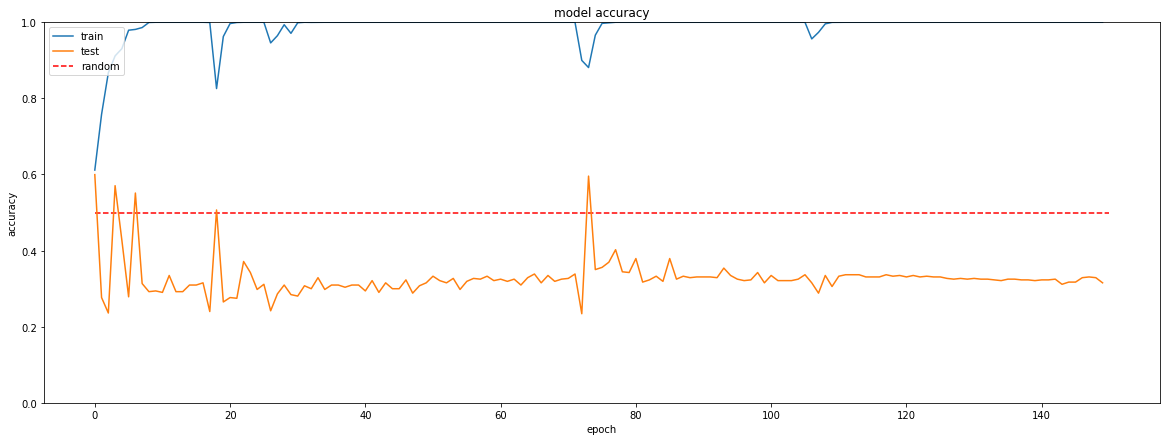

In [27]:
plt.rcParams['figure.figsize'] = (20,7)
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="test")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.hlines(y=0.5, xmin=0, xmax=len(history.history["accuracy"]), color="red", linestyles="dashed", label="random")
plt.ylim([0, 1])
plt.legend()
plt.legend(
  #['train', 'test'],
    loc='upper left')
plt.savefig("../plots/experiment_2.png")
plt.show()


In [29]:
# data.load(model_name)

Evaluate on training set

Positive control -> it should have high accuracy since the model saw this data already

In [34]:
# evaluate the model
loss, acc = data.model.evaluate(*dataset_split["train"][:2], verbose=0)
test_str = 'Train accuracy: %.4f' % acc
print(test_str)
with open(test_str_txt, "w") as fh:
    fh.write(test_str + '\n')

Train accuracy: 0.9807


Evaluate on test set

Experiment -> if this is high, the model actually learnt, otherwise it didn't, no matter how high the training set accuracy is

In [35]:
# evaluate the model
loss, acc = data.model.evaluate(*dataset_split["test"][:2], verbose=3)
test_str = 'Test Accuracy: %.3f' % acc
print(test_str)
with open(test_str_txt, "w") as fh:
    fh.write(test_str + '\n')

Test Accuracy: 0.302


In [39]:
loss

5.044247956986123

In [93]:
data.save(model_name)

Saved model to disk


AttributeError: 'NoneType' object has no attribute 'summary'

In [95]:
np.mean(dataset_split["test"][1])

0.7408123791102514

In [100]:
#data.model.predict([dataset_split["test"][0][0,:].tolist()])
# make a prediction

yhat = data.predict([dataset_split["test"][0][4,:].tolist()])
print('Predicted score: %.3f' % list(yhat.values())[0])
print('Predicted class: %d' % list(yhat.keys())[0])
print(f"Should be {dataset_split['test'][1][0]}")

Predicted score: 0.997
Predicted class: 0
Should be 1


In [ ]:
# data.get_labels(encode=False)[:3]
# data.get_labels()[:3]

In [101]:
class_scores = []
class_preds = []

test_data = dataset_split["test"][0]

for i in tqdm(range(test_data.shape[0])):
    yhat = data.predict([test_data[i,:].tolist()])
    class_preds.append(list(yhat.keys())[0])
    class_scores.append(list(yhat.values())[0])

/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/517 [00:00<?, ?it/s]

In [102]:
ytrue = dataset_split["test"][1]

summ = pd.DataFrame({
    "yhat": class_scores,
    "class": class_preds,
    "ytrue": ytrue,
})

In [103]:
summ["correct_pred"] =  summ.values[:,1] == summ.values[:,2]
summ["incorrect_pred"] = summ.values[:,1] != summ.values[:,2]
summ


,yhat,class,ytrue,correct_pred,incorrect_pred
0,0.960939,1,1,True,False
1,0.551575,0,0,True,False
2,0.997476,1,1,True,False
3,1.000000,1,0,False,True
4,0.996633,0,0,True,False
...,...,...,...,...,...
512,0.991901,0,0,True,False
513,0.993143,0,1,False,True
514,1.000000,1,1,True,False
515,0.997333,1,1,True,False


In [104]:
#dataset_split["test"][2]

In [105]:
test_obs = pd.merge(dataset_split["test"][2], data.obs, how="left")

TypeError: Can only merge Series or DataFrame objects, a <class 'numpy.ndarray'> was passed

In [106]:
summ=pd.concat([summ, test_obs],axis=1)

NameError: name 'test_obs' is not defined

In [107]:
summ.head()

,yhat,class,ytrue,correct_pred,incorrect_pred
0,0.960939,1,1,True,False
1,0.551575,0,0,True,False
2,0.997476,1,1,True,False
3,1.000000,1,0,False,True
4,0.996633,0,0,True,False


In [66]:
summ.groupby("Condition").sum()

,yhat,class,ytrue,correct_pred,incorrect_pred,Clusterings.0,Clusterings.1,Clusterings.2,Clusterings.3,Clusterings.4,...,Embeddings_Y.2,Percent_mito,detected,discard,nGene,nUMI,propZero,sizeFactor,sum,total
Condition,,,,,,,,,,,,,,,,,,,,,
ZT 14 SD,31.197010,94,96,31,1,96,128,96,128,128,...,29.591022,3.640718,58805.0,2,58805,205914.0,26.116558,29.317875,205914.0,205914.0
ZT 14 sleep,77.802381,231,237,76,3,261,316,237,316,316,...,34.708839,10.276807,145030.0,9,145030,521367.0,64.489746,74.725090,521367.0,521367.0
ZT 2 rebound 12h SD,226.487216,443,428,219,10,735,916,687,916,916,...,17.029377,25.054203,436838.0,30,436838,1795278.0,185.294342,255.774628,1795278.0,1795278.0
ZT 2 sleep drive 14h SD,144.128526,229,226,140,5,459,580,435,580,580,...,8.989573,15.420468,267025.0,18,267025,1004200.0,118.284142,141.358109,1004200.0,1004200.0
ZT 20 midline cross,88.244600,177,178,88,1,283,356,267,356,356,...,22.005627,6.570885,175916.0,12,175916,673128.0,71.399597,96.645912,673128.0,673128.0
ZT 20 sleep,287.025583,548,528,262,36,926,1192,894,1192,1192,...,100.646004,24.244793,548298.0,49,548298,2002588.0,243.142776,301.424683,2002588.0,2002588.0
ZT 20 sleep deprivation,215.223485,401,369,194,30,696,896,672,896,896,...,71.477463,21.231804,411345.0,36,411345,1459433.0,182.844925,219.431213,1459433.0,1459433.0
ZT 8 20h SD,63.190920,342,362,55,14,207,276,207,276,276,...,40.386845,6.251998,114716.0,20,114716,395232.0,57.522663,62.329391,395232.0,395232.0
ZT 8 gab,76.115061,420,438,71,10,251,324,243,324,324,...,72.935493,7.518210,129407.0,21,129407,400524.0,68.052826,63.522930,400524.0,400524.0


In [67]:
summ.groupby("Genotype").sum()

,yhat,class,ytrue,correct_pred,incorrect_pred,Clusterings.0,Clusterings.1,Clusterings.2,Clusterings.3,Clusterings.4,...,Embeddings_Y.2,Percent_mito,detected,discard,nGene,nUMI,propZero,sizeFactor,sum,total
Genotype,,,,,,,,,,,,,,,,,,,,,
line_287,155.409705,579,573,144,16,488,640,480,640,640,...,107.590340,13.756172,260098.0,15,260098,798320.0,133.977188,119.779808,798320.0,798320.0
line_303,162.372277,396,397,146,20,522,664,498,664,664,...,44.577148,15.555780,320399.0,27,320399,1309891.0,133.944077,192.866348,1309891.0,1309891.0
line_313,68.884057,68,67,69,1,234,280,210,280,280,...,24.431211,3.838529,151599.0,15,151599,621403.0,54.832516,98.771049,621403.0,621403.0
line_359,15.751792,4,0,15,1,48,64,48,64,64,...,17.128075,0.794291,31909.0,4,31909,124335.0,12.807504,20.968523,124335.0,124335.0
line_379,259.685716,655,656,244,26,850,1080,810,1080,1080,...,87.123665,26.131338,503289.0,50,503289,1864700.0,219.645920,280.476501,1864700.0,1864700.0
line_441,242.670214,524,515,229,19,776,992,744,992,992,...,110.844986,20.976332,446411.0,39,446411,1567675.0,203.336563,234.721939,1567675.0,1567675.0
line_646,109.026463,353,351,106,7,387,452,339,452,452,...,38.902752,11.826299,203800.0,20,203800,771933.0,92.609802,115.383301,771933.0,771933.0
line_88,247.688806,320,306,239,14,767,1012,759,1012,1012,...,104.420280,22.582960,468627.0,29,468627,1627937.0,206.113861,245.407028,1627937.0,1627937.0
line_892,63.732961,100,101,63,1,200,256,192,256,256,...,-9.215744,6.604895,125218.0,9,125218,527045.0,51.471935,72.548286,527045.0,527045.0


In [68]:
summ.groupby("Run").sum()

,yhat,class,ytrue,correct_pred,incorrect_pred,Clusterings.0,Clusterings.1,Clusterings.2,Clusterings.3,Clusterings.4,...,Embeddings_Y.2,Percent_mito,detected,discard,nGene,nUMI,propZero,sizeFactor,sum,total
Run,,,,,,,,,,,,,,,,,,,,,
20180419,234.614130,31,0,232,8,760,960,720,960,960,...,174.983536,10.607087,461040.0,51,461040,1645433.0,193.872940,273.382324,1645433.0,1645433.0
20191009,337.009635,370,342,329,13,1066,1368,1026,1368,1368,...,-48.366936,45.411392,624681.0,37,624681,2294930.0,279.500641,323.791565,2294930.0,2294930.0
20191023,347.025318,696,698,340,9,1119,1396,1047,1396,1396,...,74.231094,27.350485,693884.0,50,693884,2869214.0,279.576874,411.135834,2869214.0,2869214.0
20191106,155.878722,466,474,154,4,498,632,474,632,632,...,82.272377,19.257898,284178.0,14,284178,998975.0,129.567978,142.707123,998975.0,998975.0
20200902,123.954674,578,548,81,56,419,548,411,548,548,...,106.674614,9.142261,239939.0,31,239939,825073.0,112.994095,130.569183,825073.0,825073.0
20200916,158.344620,817,845,147,22,515,676,507,676,676,...,138.321213,14.019900,281692.0,23,281692,897814.0,140.816711,140.956940,897814.0,897814.0
20200924,58.847145,354,366,55,6,183,244,183,244,244,...,49.339127,5.373086,97674.0,22,97674,318336.0,51.227715,51.743824,318336.0,318336.0


In [53]:
summ.to_csv(summary_csv)

In [159]:
# summ["Condition"].value_counts()

ZT 20 sleep                271
ZT 20 sleep deprivation    230
ZT 2 rebound 12h SD        208
ZT 2 sleep drive 14h SD    167
ZT 8 wake                  155
ZT 14 sleep                 90
ZT 20 midline cross         87
ZT 8 gab                    82
ZT 8 20h SD                 81
ZT 14 SD                    45
ZT 8 wake stimulation       40
Name: Condition, dtype: int64

In [ ]:
# # data.sequential_model()
# model1 = Sequential()
# model1.add(Dense(1000, activation='relu', kernel_initializer='he_normal', name="dense_1", input_shape=(data.n_features,)))
# # model.add(Dense(10, activation='relu', kernel_initializer='he_normal', name="dense_2"))
# # model.add(Dense(300, activation='relu', kernel_initializer='he_normal', name="dense_3"))
# # model.add(Dense(200, activation='relu', kernel_initializer='he_normal', name="dense_4"))

# # model.add(Dense(n_classes, activation="softmax", name="output"))
# model.add(Dense(1, activation="sigmoid", name="output"))

# data._model = model